In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd/content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install tensorflow-addons

In [4]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

from statsmodels.tsa.arima_model import ARIMA

import keras
from tensorflow_addons.layers import MultiHeadAttention

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [5]:
## 중량 수온 데이터를 합친 dataframe, 품목 별로 불러오기

data = pd.read_excel("./bigcon.xlsx")
val_df = pd.read_excel("./vali.xlsx")

name = "흰다리새우" 

if name == "오징어":
  data = pd.read_csv("./squid_temp1.csv")
  val_df = pd.read_csv("./squid_temp2.csv")
elif name == "흰다리새우":
  data = pd.read_csv("./shrimp_temp1.csv")
  val_df = pd.read_csv("./shrimp_temp2.csv")
elif name == "연어":
  data = pd.read_csv("./salmon_temp1.csv")
  val_df = pd.read_csv("./salmon_temp2.csv")
else:
  None

In [6]:
## 품목별 dataframe을 생성하고, 일자별 거래의 갯수를 리스트 형태로 저장
def datasetting(data, p_name):

  just_p = pd.DataFrame(columns=data.columns.tolist())
  len_list = []
  for i, day_time in enumerate(list(Counter(data['REG_DATE']).keys())):
    day_df = data[data['REG_DATE']==day_time]
    just_p = pd.concat([just_p, day_df[day_df['P_NAME']==p_name]])
    len_list.append(len(day_df[day_df['P_NAME']==p_name]))

  return just_p, len_list

In [7]:
## import type을 multi-hot encoding 하기 위한 방법
def data_encoding(df, type_):
  tmp = []
  for impo in df[type_]:
    types = impo.split(',')
    for i in types:
      tmp.append(i)
  return list(set(tmp))

In [8]:
train, t_len = datasetting(data, name)
validation, v_len = datasetting(val_df, name)

In [9]:
train

,Unnamed: 0,Unnamed: 0.1,REG_DATE,date,date_m,date_y,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,WEIGHT(KG),TOTAL_PRICE,P_PRICE,S_PRICE,temp
0,0,0,2015-12-28,2015-12-28,2015-12,2015,수산물,사우디아라비아,사우디아라비아,판매용,갑각류,새우,흰다리새우,냉동,17280.00,0.00,6.019444,0.000000,26.999450
1,1,1,2015-12-28,2015-12-28,2015-12,2015,수산물,에콰도르,에콰도르,판매용,갑각류,새우,흰다리새우,냉동,21360.00,0.00,8.281805,0.000000,27.652058
2,2,2,2015-12-28,2015-12-28,2015-12,2015,수산물,말레이시아,말레이시아,판매용,갑각류,새우,흰다리새우,냉동,8718.00,48993.00,6.171628,5.619752,28.405743
3,3,3,2015-12-28,2015-12-28,2015-12,2015,수산물,베트남,베트남,판매용,갑각류,새우,흰다리새우,"냉동,살,포장횟감",995.00,14147.00,12.903215,14.218090,26.808283
4,4,4,2015-12-28,2015-12-28,2015-12,2015,수산물,태국,태국,판매용,갑각류,새우,흰다리새우,냉장,325.00,0.00,9.125593,0.000000,29.121342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,1608,1608,2019-12-30,2019-12-30,2019-12,2019,수산물,태국,태국,판매용,갑각류,새우,흰다리새우,"냉동,살",11129.28,122470.32,11.912033,11.004335,25.655415
1609,1609,1609,2019-12-30,2019-12-30,2019-12,2019,수산물,말레이시아,말레이시아,판매용,갑각류,새우,흰다리새우,냉동,12565.00,0.00,7.682474,0.000000,27.348827
1610,1610,1610,2019-12-30,2019-12-30,2019-12,2019,수산물,태국,태국,판매용,갑각류,새우,흰다리새우,냉장,480.00,5520.00,11.500000,11.500000,25.655415
1611,1611,1611,2019-12-30,2019-12-30,2019-12,2019,수산물,에콰도르,에콰도르,판매용,갑각류,새우,흰다리새우,냉동,21528.00,0.00,6.739527,0.000000,26.165197


In [10]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(train['CTRY_1']))+list(set(train['CTRY_2'])))
ctry_2 = set(list(set(validation['CTRY_1']))+list(set(validation['CTRY_2'])))
con = list(ctry_1) + list(ctry_2)
ctry_list = list(set(con))

In [11]:
## 명목형 변수는 dummy 처리해서 multi-hot 형태로 할당하고, 수치형 변수는 스케일링 작업 진행

def data_frame(trains, ctry_list):

  p_type = "P_IMPORT_TYPE"
  import_type = data_encoding(train, p_type)

  con = ctry_list
  con.sort()
  col_con = [f"country_{co}" for co in con]
  col_imp = [f"import_{im}" for im in import_type]
  cols = col_con + col_imp + ['weight', 'temp', 'price']
  # print(cols)
  x_train = pd.DataFrame(columns=cols)
  tmp = []
  for i in range(len(cols)-1):
    tmp.append([])
  len_a = len(col_con)
  len_b = len(col_imp)
  for c1, c2, p in zip(trains['CTRY_1'], trains['CTRY_2'], trains['P_IMPORT_TYPE']):
    i = con.index(c1)
    j = con.index(c2)
    country = np.eye(len_a)[i] + np.eye(len_a)[j] ## 제조국 + 수출국 정보 결합

    p_import = np.zeros(len_b)
    for ty in p.split(','):
      j = import_type.index(ty)
      p_import += np.eye(len(p_import))[j] ## import type 정보 결합

    row = np.concatenate([country, p_import])

    for i, r in enumerate(row):
      tmp[i].append(r)

  for i, c in enumerate(cols[:-3]): ## 중량, 수온, 가격 이외의 것들만 고려
    x_train[c] = tmp[i]

  ## 중량과 수온 데이터 스케일링
  w = trains['WEIGHT(KG)'].tolist()
  w = np.array(w).reshape(-1,1)
  t = trains['temp'].tolist()
  t = np.array(t).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(w)
  t_data = scaler.transform(w)

  wscaler = MinMaxScaler()
  wscaler.fit(t)
  w_data = wscaler.transform(t)

  x_train['weight'] =  t_data
  x_train['temp'] = w_data
  x_train['price'] = trains['P_PRICE'].tolist()

  return x_train

In [12]:
x_train = data_frame(train, ctry_list)

In [13]:
x_val = data_frame(validation, ctry_list)

In [57]:
x_train = x_train.drop(['temp'],axis=1)
x_val = x_val.drop(['temp'], axis=1)

In [58]:
## 수입목적도 같이 고려할경우 사용

def p_purpose(df, data):
  p_df = pd.get_dummies(data[['P_PURPOSE']])
  c_df = pd.concat([df.iloc[:,:-1], p_df, df.iloc[:,-1]], axis=1)
  return c_df

In [59]:
## 수입목적 고려하도록 변수 재설정

x_train = p_purpose(x_train, train)
x_val = p_purpose(x_val, validation)

In [60]:
X_train = np.array(x_train.iloc[:,:-1])
Y_train = np.array(x_train.iloc[:,-1])
Y_train = Y_train.reshape(-1)

In [61]:
X_val = np.array(x_val.iloc[:,:-1])
Y_val = np.array(x_val.iloc[:,-1])
Y_val = Y_val.reshape(-1)

In [62]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1613, 23), (1613,), (287, 23), (287,))

In [63]:
num_heads=8; head_size=32; ff_dim=None; dropout=0

multi = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)

In [64]:
## Attention을 계산하는 모듈 생성

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=8, head_size=128, ff_dim=None, dropout=0.2, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(1)
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)
        
        return x

In [65]:
## Attention을 여러번 계산하고 마치막 출력으로 Fully_connected layer를 통해 차원 축소

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', num_heads=8, head_size=128, ff_dim=None, num_layers=10, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
      self.dense2 = keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
      x = inputs
      for attention_layer in self.attention_layers:
          x = attention_layer(x)
      x = self.dense2(x)
      return x

In [66]:
attention_layers = ModelTrunk()

In [67]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [68]:
def make_weight(x, y,length):
    # 날짜별로 attention score 담을 list
    weight_score = []
    # 날짜별로 p_price 담을 list
    p_price = []
    final_weight = []

    before = 0
    for leng in length:
      if leng==0:
        weight_score.append([[0]])
        p_price.append([[0]])
      else:
        a = np.array(x[before:before+leng])
        b = np.array(y[before:before+leng]).tolist()
        arr = attention_layers(a)
        weight_score.append(np.array(softmax(arr)).tolist()) ## attention score를 softmax 함수를 이용해서 정규화
        p_price.append(b)
        before += leng

    for w in weight_score:
        aa = sum(w, [])
        final_weight.append(aa)

    return final_weight,p_price

In [69]:
train_weight, train_price = make_weight(X_train, Y_train, t_len)

In [70]:
val_weight, val_price = make_weight(X_val, Y_val,v_len)

In [71]:
def make_new_price(weight_list, price_list):
    new_price = []
    new_price_m = 0
    new_price_s = 0

    for i in range(len(weight_list)):
        if weight_list[i]==[0]:
            new_price.append(0)
        else:
            for j in range(len(weight_list[i])):
                new_price_m += (weight_list[i][j] * price_list[i][j])
                new_price_s += weight_list[i][j]
            new_price_sum = new_price_m / new_price_s
            new_price.append(new_price_sum)
    return new_price

In [72]:
train_price = make_new_price(train_weight, train_price)

In [73]:
val_price = make_new_price(val_weight, val_price)

In [74]:
trn_lst = np.array([item for item in train_price if item > 0])

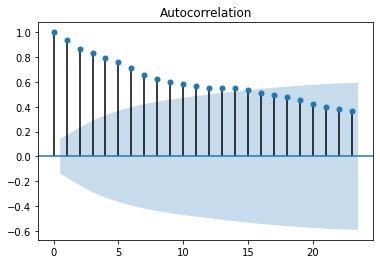

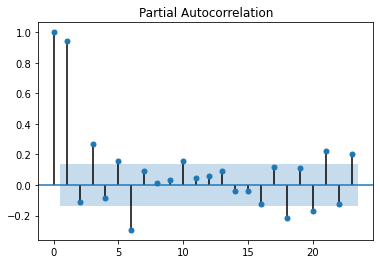

In [75]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(np.array(train_price))
plot_pacf(np.array(train_price))
plt.show()

In [76]:
ts_train = np.array(train_price)

In [77]:
model = ARIMA(trn_lst, order=(0,2,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  195
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 139.597
Method:                       css-mle   S.D. of innovations              0.117
Date:                Tue, 14 Sep 2021   AIC                           -273.195
Time:                        10:35:59   BIC                           -263.376
Sample:                             2   HQIC                          -269.219
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.877      0.062      -0.001    1.23e-05
ma.L1.D2.y    -1.0000      0.015    -66.724      0.000      -1.029      -0.971
                                    Roots           

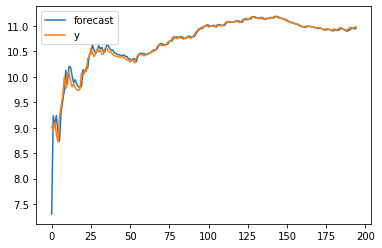

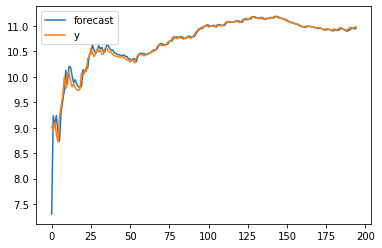

In [78]:
model_fit.plot_predict()

In [79]:
fore = model_fit.forecast(steps=52)

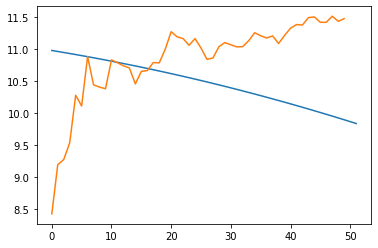

In [80]:
plt.plot(fore[0])
plt.plot(val_price)

In [81]:
## 프로펫에 피팅하기 위해서 dataframe 형태 수정

prophet_df = pd.DataFrame(columns=['ds','y'])
prophet_df['ds'] = list(Counter(data['REG_DATE']).keys())
prophet_df['y'] = ts_train

In [82]:
m = Prophet(changepoint_prior_scale=0.3)
m.fit(prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [83]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

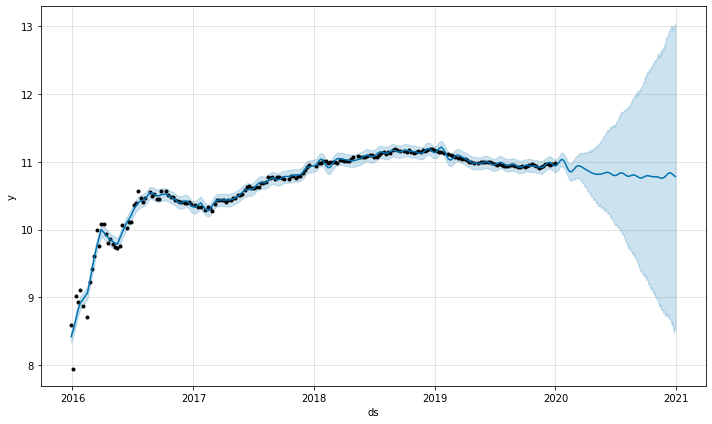

In [84]:
fig1 = m.plot(forecast)

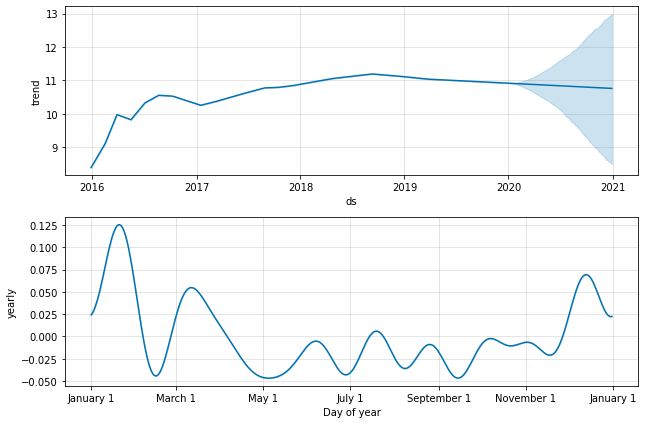

In [85]:
fig2 = m.plot_components(forecast)

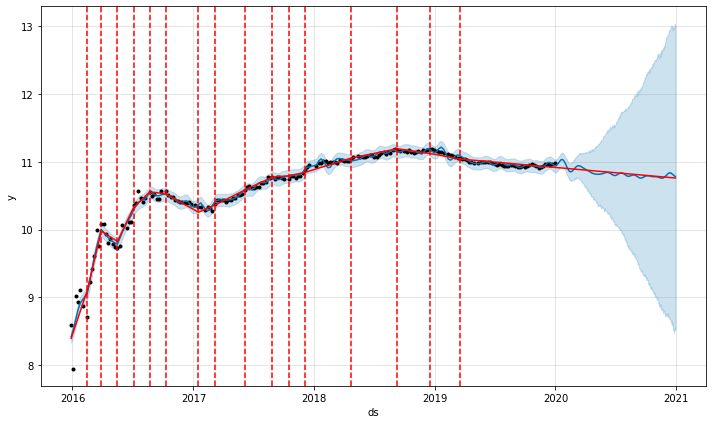

In [86]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

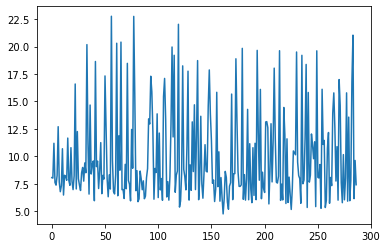

In [87]:
plt.plot(Y_val)

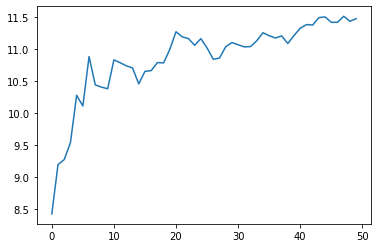

In [88]:
plt.plot(val_price)

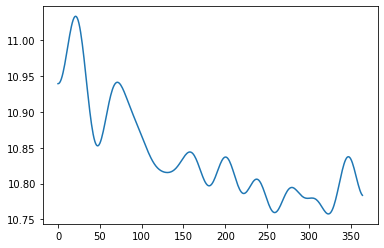

In [89]:
plt.plot(list(forecast[-365:]['yhat']))

In [90]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-12-28,8.395316,8.328760,8.511266,8.395316,8.395316,0.025275,0.025275,0.025275,0.025275,0.025275,0.025275,0.0,0.0,0.0,8.420592
1,2016-01-04,8.496995,8.441610,8.622852,8.496995,8.496995,0.030773,0.030773,0.030773,0.030773,0.030773,0.030773,0.0,0.0,0.0,8.527768
2,2016-01-11,8.598675,8.577528,8.763263,8.598675,8.598675,0.074435,0.074435,0.074435,0.074435,0.074435,0.074435,0.0,0.0,0.0,8.673109
3,2016-01-18,8.700354,8.724191,8.909761,8.700354,8.700354,0.118734,0.118734,0.118734,0.118734,0.118734,0.118734,0.0,0.0,0.0,8.819087
4,2016-01-25,8.802033,8.828253,9.015657,8.802033,8.802033,0.117074,0.117074,0.117074,0.117074,0.117074,0.117074,0.0,0.0,0.0,8.919107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,2020-12-25,10.762738,8.474065,12.985547,8.529026,12.952219,0.031728,0.031728,0.031728,0.031728,0.031728,0.031728,0.0,0.0,0.0,10.794466
558,2020-12-26,10.762308,8.531734,12.991740,8.522570,12.964186,0.028499,0.028499,0.028499,0.028499,0.028499,0.028499,0.0,0.0,0.0,10.790808
559,2020-12-27,10.761879,8.512939,13.038266,8.516115,12.976153,0.025839,0.025839,0.025839,0.025839,0.025839,0.025839,0.0,0.0,0.0,10.787718
560,2020-12-28,10.761450,8.557933,13.010440,8.509659,12.979876,0.023853,0.023853,0.023853,0.023853,0.023853,0.023853,0.0,0.0,0.0,10.785303


In [91]:
## 평가 데이터에서 날짜 추출

date_col = list(set(val_df['REG_DATE']))
date_col.sort()

In [92]:
## 평가 데이터에서 날짜 기반으로 프로펫에서 예측한 정보 추출

pred_data = pd.DataFrame(columns=list(forecast.columns))
for i in date_col:
  pred_data = pd.concat([pred_data, forecast[forecast['ds']==i]])

len(pred_data['yhat'])

50

In [93]:
just_mean = list(validation['P_PRICE'].groupby(validation['REG_DATE']).mean())

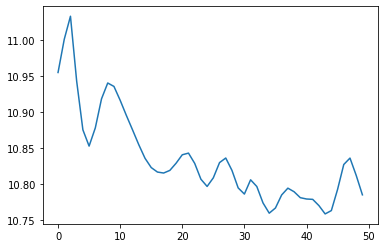

In [94]:
plt.plot(list(pred_data['yhat']), label="predinction")

In [96]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(just_mean, pred_data['yhat'])**0.5   ## 단순 평균과 예측한 데이터 간에 RMSE값 산출
RMSE

1.729307522200895

In [97]:
RMSE = mean_squared_error(val_price, pred_data['yhat'])**0.5   ## attention을 고려한 가중 평균 데이터와 예측한 데이터 간에 RMSE값 산출
RMSE

0.6792447668985347